In [105]:
#Load in required packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy

import sys
import glob
import os

#For converting between geolocal and numerical ages
from pyrolite.util.time import Timescale

sys.path.insert(1, '../pygplates_rev28_python37_win64')
import pygplates
import ptt

import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#For plotting histograms
from itertools import combinations

In [153]:
#Pick a dataset

#df=pd.read_csv("mldata_CO2.csv")
# df=pd.read_csv("mldata_Hf.csv")
# df=pd.read_csv("mldata_Hf176_Hf177.csv")
# df=pd.read_csv("mldata_Nd.csv")
# df=pd.read_csv("mldata_Nd143_Nd144.csv")
# df=pd.read_csv("mldata_Pb207_Pb204.csv")
df

,Nd,gridage,gridcrust,gridsubcrust,gridlith,gridsublith,gridsed,gridsubsed,gridsubserp,gridslabtop,gridslabage,gridslabdip,gridslabthick,gridslabvel,gridslabsubage,random,vol
0,NaN,27.215429,0.000006,NaN,0.000004,NaN,0.000046,NaN,NaN,550.0,NaN,NaN,NaN,NaN,26.414402,4,NaN
1,84.15,105.411903,0.000009,0.000069,0.000004,0.000041,0.000006,0.000039,0.000718,210.0,32.78672,22.01977,225093.375,0.000875,26.285441,1,4.0
2,NaN,27.176504,0.000006,0.000018,0.000004,0.000008,0.000046,0.000005,0.000003,460.0,NaN,NaN,NaN,NaN,25.345132,5,NaN
3,NaN,121.650185,0.000009,0.000026,0.000004,0.000018,0.000129,0.000072,0.000003,160.0,NaN,NaN,NaN,NaN,39.000000,2,NaN
4,NaN,121.650185,0.000009,0.000026,0.000004,0.000018,0.000129,0.000072,0.000003,160.0,NaN,NaN,NaN,NaN,39.000000,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,13.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0.0
968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN


In [154]:
#vol is the "vol"canic target feature
df.vol.count()
#This is the number of features we will have for trianing/testing.

300

In [155]:
#Drop any lines that do not have the target value (i.e. where vol=Na)
dfsub=df.dropna(subset=['vol'])
dfsub

,Nd,gridage,gridcrust,gridsubcrust,gridlith,gridsublith,gridsed,gridsubsed,gridsubserp,gridslabtop,gridslabage,gridslabdip,gridslabthick,gridslabvel,gridslabsubage,random,vol
1,84.15,105.411903,0.000009,0.000069,0.000004,0.000041,0.000006,0.000039,0.000718,210.0,32.786720,22.019770,225093.375000,0.000875,26.285441,1,4.0
48,38.70,81.736115,0.000009,0.000024,0.000004,0.000016,0.000004,0.000006,0.000027,260.0,28.127666,23.721504,67457.679688,0.014363,59.000000,2,2.0
49,77.80,81.736115,0.000009,0.000024,0.000004,0.000016,0.000004,0.000006,0.000027,260.0,28.127666,23.721504,67457.679688,0.014363,59.000000,4,4.0
61,28.30,105.411903,0.000009,0.000069,0.000004,0.000041,0.000006,0.000039,0.000718,210.0,32.786720,22.019770,225093.375000,0.000875,26.285441,1,2.0
70,56.40,81.736115,0.000009,0.000016,0.000004,0.000011,0.000004,0.000004,0.000019,260.0,NaN,NaN,NaN,NaN,59.000000,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,11.91,106.872726,0.000007,NaN,0.000004,NaN,NaN,NaN,NaN,210.0,NaN,NaN,NaN,NaN,155.321807,4,0.0
963,21.40,114.626854,0.000003,0.000025,0.000004,0.000036,NaN,NaN,0.000019,220.0,117.840683,29.736578,333477.500000,0.037272,109.744949,2,1.0
965,16.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1.0
966,18.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0


In [156]:
#Set the list of parameter variable names we will use

#Set the target feature
targets = dfsub['vol']

#Set the signifcant variables we will use for ML
#Use "random" varibale to benchmark against
#Drop gridserp because of too many nans.
sigvars=['random','gridage', 'gridcrust', 'gridsubcrust', 'gridlith', 'gridsublith', 'gridsed', 'gridsubsed', 'gridsubserp',
        'gridslabage','gridslabdip','gridslabthick','gridslabvel','gridslabsubage']

## BIG assumption here! Multiple ways to do this. But this may work okay for THESE data grids.
#Replace nans with 0 and set significant variables
features=dfsub[sigvars].fillna(0)


## ML method 1 - Random Forest

In [157]:
#Create the ML classifier with numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
   ('imputer', SimpleImputer(strategy='constant')),
   ('onehot', OneHotEncoder(handle_unknown='ignore'))])


#If using categorical data, uncomment the cat part
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, sigvars)])
#         ('cat', categorical_transformer, catvars)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
rf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', RandomForestClassifier())])


#                      ('classifier', RandomForestClassifier())])


Random Forest...
Done RF
RF 10-fold cross validation Scores: [0.233 0.233 0.367 0.433 0.233 0.333 0.4   0.267 0.367 0.133]
SCORE Mean: 0.30 STD: 0.09 



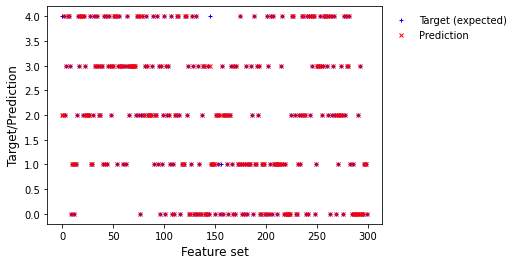

In [158]:
#Train the random forest
print('Random Forest...')

rf.fit(features,targets)
print("Done RF")

scores = cross_val_score(rf, features,targets, cv=10)
print("RF 10-fold cross validation Scores:", scores)
print("SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores), "\n")

plt.plot(targets.values,'b+',label='Target (expected)')
plt.plot(rf.predict(features),'rx',label='Prediction')
plt.xlabel("Feature set")
plt.ylabel("Target/Prediction")
plt.legend()

In [159]:
#Get the most "significant" feature values and labels
ft_imp=[]
ft_lab=[]
np.set_printoptions(precision=3,suppress=True)

#Uncomment ff having categorical data also
#for i,lab in enumerate(np.append(sigvars,rf['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(catvars))):

#Uncomment if just numerical data
for i,lab in enumerate(sigvars):
    #if rf.steps[1][1].feature_importances_[i] > 1*np.mean(rf.steps[1][1].feature_importances_): 
    #print(i, rf.steps[1][1].feature_importances_[i],lab )
    print("%1.3f \t %s" % (rf.steps[1][1].feature_importances_[i],lab))
    ft_imp.append(rf.steps[1][1].feature_importances_[i])
    ft_lab.append(lab)

0.073 	 random
0.090 	 gridage
0.107 	 gridcrust
0.071 	 gridsubcrust
0.094 	 gridlith
0.068 	 gridsublith
0.081 	 gridsed
0.064 	 gridsubsed
0.071 	 gridsubserp
0.051 	 gridslabage
0.055 	 gridslabdip
0.046 	 gridslabthick
0.047 	 gridslabvel
0.084 	 gridslabsubage


From the Random Forest ML algorithm,
these are the the most significant features for predicting the 5 target bins (of the chemistry)


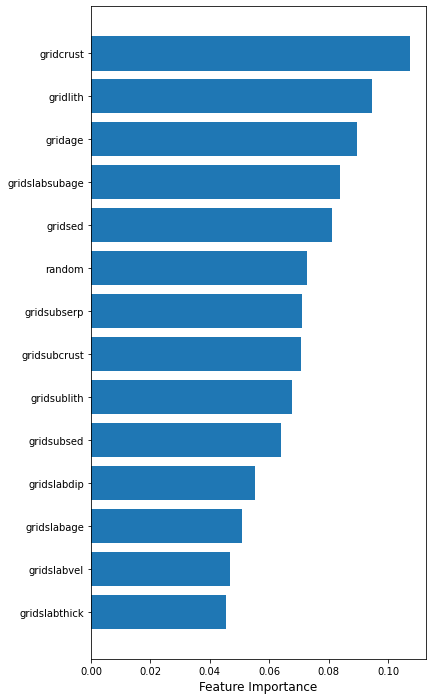

In [160]:
#Make the bar plot
ft_imps, ft_labs = (list(t) for t in zip(*sorted(zip(ft_imp,ft_lab))))

datalength=len(ft_imp)

#Create a new figur
#fig = plt.figure(figsize=(10,10),dpi=150)
fig,ax = plt.subplots(figsize=(6,12))

#Plot the bar graph
rects=ax.barh(np.arange(0, datalength, step=1),ft_imps)

#Label the axes
ax.set_yticks(np.arange(0, datalength, step=1))
ax.set_yticklabels(ft_labs)

ax.set_xlabel('Feature Importance')

#Print the feature importance to compare with plot
np.set_printoptions(precision=3,suppress=True)
# print("Importance \t Feature")
# for i,label in enumerate(ft_lab):
#     print("%1.3f \t\t %s" % (ft_imp[i],ft_lab[i]))

print("From the Random Forest ML algorithm,")
print("these are the the most significant features for predicting the 5 target bins (of the chemistry)")
plt.show()

## ML Method 2 - Neural Network Classification

MLP Neural Network...
Done MLP
RF 10-fold cross validation Scores: [0.267 0.3   0.3   0.367 0.2   0.333 0.233 0.267 0.233 0.133]
SCORE Mean: 0.26 STD: 0.06 



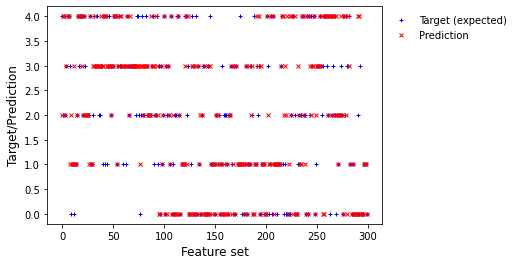

In [161]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=200,activation = 'relu',solver='adam',random_state=123)
pipe = Pipeline(steps=[('pre',preprocessor),('mlpc', mlp)])

#Train the random forest
print('MLP Neural Network...')

pipe.fit(features,targets)
print("Done MLP")

scores = cross_val_score(pipe, features,targets, cv=10)
print("RF 10-fold cross validation Scores:", scores)
print("SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores), "\n")

plt.plot(targets.values,'b+',label='Target (expected)')
plt.plot(pipe.predict(features),'rx',label='Prediction')
plt.xlabel("Feature set")
plt.ylabel("Target/Prediction")
plt.legend()

## ML Method 3 - Ada Boost 

MLP Boost Ensemble...
Done Boosting
RF 10-fold cross validation Scores: [0.333 0.2   0.2   0.267 0.133 0.133 0.333 0.233 0.167 0.167]
SCORE Mean: 0.22 STD: 0.07 



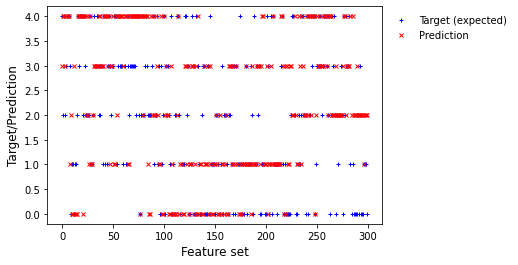

In [162]:
from sklearn.ensemble  import AdaBoostClassifier

mlp = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, algorithm='SAMME.R', random_state=1)
pipe = Pipeline(steps=[('pre',preprocessor),('mlpc', mlp)])

#Train the model
print('MLP Boost Ensemble...')

pipe.fit(features,targets)
print("Done Boosting")

scores = cross_val_score(pipe, features,targets, cv=10)
print("RF 10-fold cross validation Scores:", scores)
print("SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores), "\n")

plt.plot(targets.values,'b+',label='Target (expected)')
plt.plot(pipe.predict(features),'rx',label='Prediction')
plt.xlabel("Feature set")
plt.ylabel("Target/Prediction")
plt.legend()